### Jason-3 data
#### Download link: https://www.ncei.noaa.gov/products/jason-satellite-products

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc
import numpy as np
from pyrsimg import readTiff, imgShow, second_to_dyr


In [5]:
## jason-1, -2,-3 data
path_ja1 = 'data/jason/JA1_GPN_2PeP004_216_20020222_083242_20020222_092845.nc'
path_ja2 = 'data/jason/JA2_GPN_2PdP002_216_20080730_084446_20080730_094058.nc'
path_ja3 = 'data/jason/JA3_GPN_2PfP000_216_20160215_215622_20160215_225235.nc'
## remote sensing data
path_rsimg = 'data/rsimg/yangzonghai_s2_20200511_wgs84.tif'


In [6]:
## 1. jason altimetry data
ja1 = nc.Dataset(path_ja1)
ja2 = nc.Dataset(path_ja2)
ja3 = nc.Dataset(path_ja3)
## 2. remote sensing image
rs_img = readTiff(path_rsimg)


In [7]:
lat_20hz_ja1, lon_20hz_ja1, time_20hz_ja1 = ja1['lat_20hz'][:].flatten(), ja1['lon_20hz'][:].flatten(), ja1['time_20hz'][:].flatten()
lat_20hz_ja2, lon_20hz_ja2, time_20hz_ja2 = ja2['lat_20hz'][:].flatten(), ja2['lon_20hz'][:].flatten(), ja2['time_20hz'][:].flatten()
lat_20hz_ja3, lon_20hz_ja3, time_20hz_ja3 = ja3['data_20/latitude'][:], ja3['data_20/longitude'][:], ja3['data_20/time'][:]
time_20hz_dyr_ja1 = second_to_dyr(time_20hz_ja1)
time_20hz_dyr_ja2 = second_to_dyr(time_20hz_ja2)
time_20hz_dyr_ja3 = second_to_dyr(time_20hz_ja3)
time_20hz_dyr_ja3


array([2016.1254495 , 2016.12544951, 2016.12544951, ..., 2016.12555616,
       2016.12555617, 2016.12555617])

In [8]:
# ja2.variables.keys()
for i in range(len(ja3['data_20/ku'].variables.keys())):
    print(list(ja3['data_20/ku'].variables.keys())[i])


range_ocean
range_ocean_compression_qual
range_ocean_mle3
range_ocean_mle3_compression_qual
range_adaptive
range_adaptive_compression_qual
swh_ocean
swh_ocean_compression_qual
swh_ocean_mle3
swh_ocean_mle3_compression_qual
swh_adaptive
swh_adaptive_compression_qual
sig0_ocean
sig0_ocean_compression_qual
sig0_ocean_mle3
sig0_ocean_mle3_compression_qual
sig0_adaptive
sig0_adaptive_compression_qual
off_nadir_angle_wf_ocean
off_nadir_angle_wf_ocean_compression_qual
num_iterations_ocean
num_iterations_ocean_mle3
num_iterations_adaptive
range_ocog
sig0_ocog
ocog_qual
mqe_ocean
mqe_ocean_mle3
mqe_adaptive
peakiness
wvf_main_class


### **Calculate the surface water height** 

In [9]:
def hz01_hz20(data_01hz, time_20hz, time_01hz):
    '''
    Convert 01 hz data to 20 hz data by time nearest interpolation.
    '''
    time_20_ = np.expand_dims(time_20hz, axis=1)
    dif_time = abs(time_20_ - time_01hz)
    ind_min = dif_time.argmin(axis=1)
    data_20hz = data_01hz[ind_min]
    return data_20hz


#### **Jason-1**

In [10]:
## 1. Correction: 1Hz
geo_corr_01hz = ['rad_wet_tropo_corr', 'model_dry_tropo_corr', 'iono_corr_alt_ku', 'sea_state_bias_ku']  ## refer to the official document.
corr_01hz = 0
for cor_01hz_name in geo_corr_01hz:
  corr_01hz += ja1[cor_01hz_name][:]
corr_01hz
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = ja1['time_20hz'][:].flatten()
times_01 = ja1['time'][:]
corr_20hz = hz01_hz20(data_01hz= corr_01hz, time_20hz=times_20, time_01hz=times_01)
# times_20_ = np.expand_dims(times_20, axis=1)
# dif_time = abs(times_20_ - times_01)
# ind_min = dif_time.argmin(axis=1)
# corr_01to20 = corr_1hz[ind_min]
## 3. Calculate the corrected surface water height: 
h_cor_ja1 = ja1['alt_20hz'][:].flatten() - (ja1['range_20hz_ku'][:].flatten() + corr_20hz)
h_cor_ja1 = h_cor_ja1.filled(np.nan)
h_cor_ja1


array([125.1303,      nan, 125.0053, ..., -53.0159, -53.0159, -53.0159])

#### **Jason-2 data**

In [11]:
## 1. Correction: 1Hz. 
## Below is corrected for the MLE4 retracking range (range_20hz_ku)
geo_corr_01hz = ['rad_wet_tropo_corr', 'model_dry_tropo_corr', 'iono_corr_alt_ku', 'sea_state_bias_ku']  ## refer to the official document.
corr_01hz = 0
for cor_01hz_name in geo_corr_01hz:
  corr_01hz += ja2[cor_01hz_name][:]
corr_01hz
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = ja2['time_20hz'][:].flatten()
times_01 = ja2['time'][:]
corr_20hz = hz01_hz20(data_01hz= corr_01hz, time_20hz=times_20, time_01hz=times_01)
## 3. Calculate the corrected surface water height: 
h_cor_ja2 = ja2['alt_20hz'][:].flatten() - (ja2['range_20hz_ku'][:].flatten() + corr_20hz)
h_cor_ja2 = h_cor_ja2.filled(np.nan)
h_cor_ja2


array([nan, nan, nan, ..., nan, nan, nan])

#### **Jason-3 data**

In [12]:
## 1. Correction: 1Hz. 
## Below is corrected for the MLE4 retracking range ('data_20/ku/range_ocean')
geo_corr_01hz = ['rad_wet_tropo_cor', 'model_dry_tropo_cor_zero_altitude', 'ku/iono_cor_alt_filtered', 'ku/sea_state_bias']  ## refer to the official document.
corr_01hz = 0
for cor_01hz_name in geo_corr_01hz:
  corr_01hz += ja3['data_01/'+cor_01hz_name][:]
corr_01hz
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = ja3['data_20/time'][:].flatten()
times_01 = ja3['data_01/time'][:]
corr_20hz = hz01_hz20(data_01hz= corr_01hz, time_20hz=times_20, time_01hz=times_01)
## 3. Calculate the corrected surface water height: 
h_cor_ja3 = ja3['data_20/altitude'][:].flatten() - (ja3['data_20/ku/range_ocean'][:].flatten() + corr_20hz)
h_cor_ja3 = h_cor_ja3.filled(np.nan)
h_cor_ja3


array([nan, nan, nan, ..., nan, nan, nan])

### Visualization from global perspective

Text(0.5, 1.0, 'jason-3')

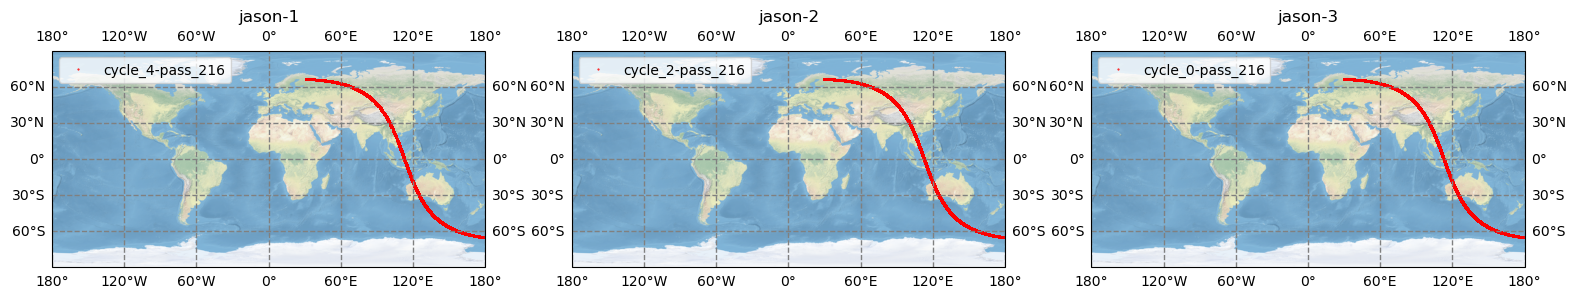

In [13]:
proj = ccrs.PlateCarree(central_longitude=0.0)
fig = plt.figure(figsize=(19,3))
orbit_ja1 = 'cycle_'+str(ja1.cycle_number)+'-pass_'+str(ja1.pass_number)
orbit_ja2 = 'cycle_'+str(ja2.cycle_number)+'-pass_'+str(ja2.pass_number)
orbit_ja3 = 'cycle_'+str(ja3.cycle_number)+'-pass_'+str(ja3.pass_number)
## jason-1
ax1 = fig.add_subplot(131, projection=proj); ax1.stock_img()
ax1.plot(lon_20hz_ja1, lat_20hz_ja1, marker='.', markersize=1, 
                                linewidth=0.0, label=orbit_ja1, color='red')
ax1.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--')
ax1.legend(); plt.title('jason-1')
## jason-2
ax2 = fig.add_subplot(132, projection=proj); ax2.stock_img()
ax2.plot(lon_20hz_ja2, lat_20hz_ja2, marker='.', markersize=1, 
                                linewidth=0.0, label=orbit_ja2, color='red')
ax2.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--')
ax2.legend(); plt.title('jason-2')
## jason-3
ax3 = fig.add_subplot(133, projection=proj); ax3.stock_img()
ax3.plot(lon_20hz_ja3, lat_20hz_ja3, marker='.', markersize=1, 
                                linewidth=0.0, label=orbit_ja3, color='red')
ax3.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--')
ax3.legend(); plt.title('jason-3')



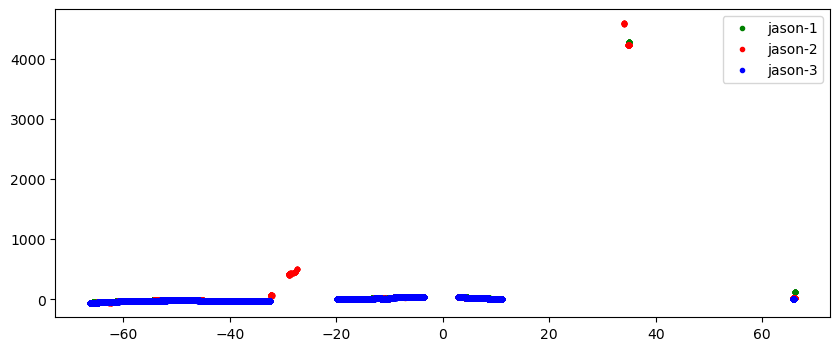

In [14]:
### visualize the elevations of the pass.
plt.figure(figsize=(10,4))
plt.plot(lat_20hz_ja1, h_cor_ja1, 'g.', label='jason-1')
plt.plot(lat_20hz_ja2, h_cor_ja2, 'r.', label='jason-2')
plt.plot(lat_20hz_ja3, h_cor_ja3, 'b.', label='jason-3')
# plt.ylim(0,50)
plt.legend()


### Visualization from local perspective

In [15]:
print(rs_img.geoextent)
ids_ja1 = np.where((lat_20hz_ja1>24.838) & (lat_20hz_ja1<24.991)) 
ids_ja2 = np.where((lat_20hz_ja2>24.838) & (lat_20hz_ja2<24.991)) 
ids_ja3 = np.where((lat_20hz_ja3>24.838) & (lat_20hz_ja3<24.991)) 


(102.93742366161841, 103.06240695261778, 24.838378597004965, 24.9916140989937)


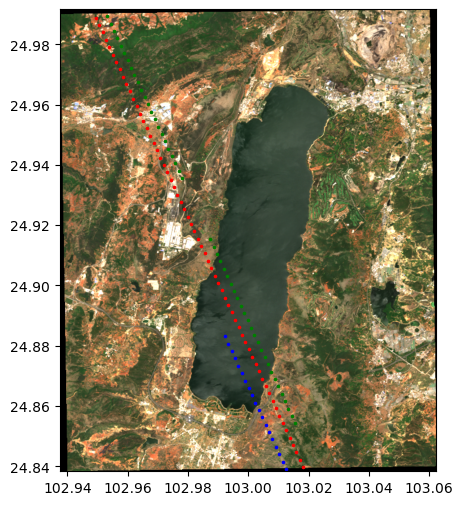

In [16]:
fig = plt.figure(figsize=(6, 6))
imgShow(rs_img.array, extent=rs_img.geoextent)
plt.scatter(x=lon_20hz_ja1[ids_ja1], y=lat_20hz_ja1[ids_ja1], s=2.5, color='blue')  ## jason data
plt.scatter(x=lon_20hz_ja2[ids_ja2], y=lat_20hz_ja2[ids_ja2], s=2.5, color='red')  ## jason data
plt.scatter(x=lon_20hz_ja3[ids_ja3], y=lat_20hz_ja3[ids_ja3], s=2.5, color='green')  ## jason data



#### !!! **No valid data (corrected height) in the specific region.**

(1853.5, 1855.5)

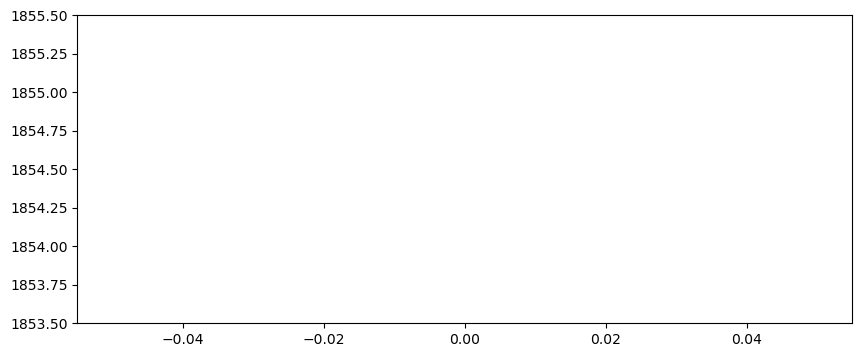

In [17]:
plt.figure(figsize=(10,4))
plt.plot(lat_20hz_ja1[ids_ja1], h_cor_ja1[ids_ja1], 'g.')
plt.plot(lat_20hz_ja2[ids_ja2], h_cor_ja2[ids_ja2], 'r.')
plt.plot(lat_20hz_ja3[ids_ja3], h_cor_ja3[ids_ja3], 'b.')
plt.ylim(1853.5, 1855.5)
